In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from hr_predictor import ROOT_PATH, data_loader
from hr_predictor.models import (
    branch_input,
    compute_error,
    get_compiled_dense_model,
    get_compiled_lstm_model,
    get_compiled_dense_lstm_model
)

# Data handling

- Creation of metadata dataframe
- patient information addition
- sync of hr and ppg signals
- normalization and filtering of ppg signals
- aggregation of data
- train/test division by patient

In [3]:
metadata_df = data_loader.generate_metadata_df()
metadata_df.head(3)

,filepaths,type,filpaths,patient
0,4TU_processed/4TU_processed/P1LC2/P1LC2.csv,hr,/home/pedro/projects/loka/4TU_processed/4TU_pr...,P1LC2
1,4TU_processed/4TU_processed/P1LC2/P1LC2_ppg.csv,ppg,/home/pedro/projects/loka/4TU_processed/4TU_pr...,P1LC2
2,4TU_processed/4TU_processed/P1LC1/P1LC1_ppg.csv,ppg,/home/pedro/projects/loka/4TU_processed/4TU_pr...,P1LC1


In [4]:
pat_data_df = data_loader.aggregate_patient_data(metadata_df,
                                                 downsampling_ratio=4)

pat_data_df.head(3)

(8968, 2) (9019, 7) (2242, 10)
(5516, 2) (5567, 7) (1362, 10)
(5511, 2) (5562, 7) (1361, 10)
(5630, 2) (5681, 7) (1391, 10)
(5492, 2) (5543, 7) (1356, 10)
(5507, 2) (5558, 7) (1360, 10)
(5503, 2) (5554, 7) (1376, 10)
(5461, 2) (5555, 7) (1348, 10)
(5701, 2) (5860, 7) (1426, 10)
(5803, 2) (5855, 7) (1434, 10)
(5650, 2) (5701, 7) (1413, 10)
(5393, 2) (5466, 7) (1332, 10)
(5378, 2) (5429, 7) (1328, 10)
(5364, 2) (5415, 7) (1324, 10)
(5403, 2) (5454, 7) (1334, 10)
(5399, 2) (5450, 7) (1333, 10)
(5521, 2) (5583, 7) (1364, 10)
(5375, 2) (5426, 7) (1327, 10)
(5381, 2) (5432, 7) (1328, 10)
(5380, 2) (5431, 7) (1345, 10)


,patient,train_test,B_raw,G_raw,R_raw,Time[ms],R,G,B,HR[bpm]
0,P1H1,train,118.554303,100.327118,85.795620,883.25,0.148813,0.144301,0.331863,170.55045
1,P1H1,train,118.355889,99.905828,85.642339,1016.75,0.329493,0.440842,0.297348,170.52630
2,P1H1,train,118.271530,100.077774,85.841903,1150.00,0.439008,0.648105,0.531917,170.14920


# EDA

## Number of patients

In [5]:
print(pat_data_df.groupby("patient").count().shape)

(20, 9)


## Plotting the raw signals

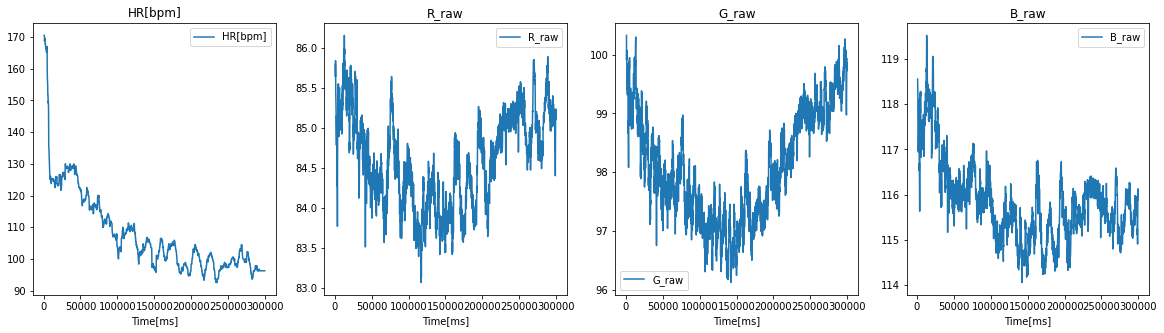

In [6]:
for pat in pat_data_df["patient"][:1].unique():
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20,5))
    pat_data_df[pat_data_df["patient"] == pat] \
        .plot(x="Time[ms]", y="HR[bpm]", ax=axes[0], title="HR[bpm]")
    pat_data_df[pat_data_df["patient"] == pat] \
        .plot(x="Time[ms]", y="R_raw", ax=axes[1], title="R_raw")
    pat_data_df[pat_data_df["patient"] == pat] \
        .plot(x="Time[ms]", y="G_raw", ax=axes[2], title="G_raw")
    pat_data_df[pat_data_df["patient"] == pat] \
        .plot(x="Time[ms]", y="B_raw", ax=axes[3], title="B_raw")

## Plotting the processed signals

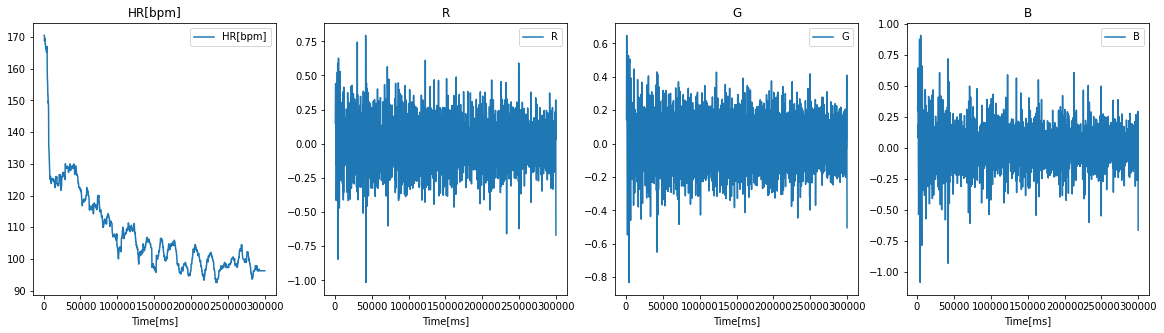

In [7]:
for pat in pat_data_df["patient"][:1].unique():
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20,5))
    pat_data_df[pat_data_df["patient"] == pat] \
        .plot(x="Time[ms]", y="HR[bpm]", ax=axes[0], title="HR[bpm]")
    pat_data_df[pat_data_df["patient"] == pat] \
        .plot(x="Time[ms]", y="R", ax=axes[1], title="R")
    pat_data_df[pat_data_df["patient"] == pat] \
        .plot(x="Time[ms]", y="G", ax=axes[2], title="G")
    pat_data_df[pat_data_df["patient"] == pat] \
        .plot(x="Time[ms]", y="B", ax=axes[3], title="B")

## Samples per patient

In [8]:
pat_data_df.groupby("patient")[["Time[ms]"]].count()

,Time[ms]
patient,
P1H1,2242
P1LC1,1362
P1LC2,1361
P1LC3,1391
P1LC4,1356
P1LC5,1360
P1LC6,1376
P1LC7,1348
P1M1,1426


# HR Prediction

Multiple alternatives can be done:
- the easiest one is using signal processing alone. In the literature this
problem is solved using only the frequency domain, or peak counting

- a la machine learning: historical features (mean, std, avg, signal
  processing features) + a model such as a LogReg/RandomForest neatly wrapped in a
  sklearn pipeline

- a la deep learning: feed a portion of a signal to a neural network based on
LSTM or FC layers
    
In all the alternatives above the objective will be predicting the n+1 HR based
on n-N_samples, where N_samples is the period of time used to obtain the HR.

For this test I'll be going with the latter approach, although it is not the most
conservative approach I'm certain I have the proper domain knowledge to build
meaningful features.

## Train test split and timeseries processing

In [9]:
period = (pat_data_df["Time[ms]"].values[1] - pat_data_df["Time[ms]"].values[0]) / 1000
# period in seconds in between samples
period

0.1335

In [10]:
# covering 6s of signal to make a predicting
INPUT_WIDTH = 100

# shuffling
pat_data_df = pat_data_df.sample(frac=1)

train_df = pat_data_df[pat_data_df["train_test"] == "train"]
test_df = pat_data_df[pat_data_df["train_test"] == "test"]

print("getting train timeseries")
x_data_train, y_data_train = data_loader.process_timeseries_data(
    train_df,
    input_width=INPUT_WIDTH
)
print("getting test timeseries")
x_data_test, y_data_test = data_loader.process_timeseries_data(
    test_df,
    input_width=INPUT_WIDTH
)


getting train timeseries
Patient: P1H1


100%|██████████| 2141/2141 [00:02<00:00, 845.75it/s]


Patient: P1LC3


100%|██████████| 1290/1290 [00:01<00:00, 840.05it/s]


Patient: P1LC5


100%|██████████| 1259/1259 [00:01<00:00, 860.10it/s]


Patient: P1LC6


100%|██████████| 1275/1275 [00:01<00:00, 847.32it/s]


Patient: P1LC7


100%|██████████| 1247/1247 [00:01<00:00, 832.27it/s]


Patient: P1M1


100%|██████████| 1325/1325 [00:01<00:00, 840.77it/s]


Patient: P1M2


100%|██████████| 1333/1333 [00:01<00:00, 841.93it/s]


Patient: P1M3


100%|██████████| 1312/1312 [00:01<00:00, 847.02it/s]


Patient: P2LC1


100%|██████████| 1231/1231 [00:01<00:00, 825.38it/s]


Patient: P2LC2


100%|██████████| 1227/1227 [00:01<00:00, 842.26it/s]


Patient: P2LC3


100%|██████████| 1223/1223 [00:01<00:00, 849.83it/s]


Patient: P2LC4


100%|██████████| 1233/1233 [00:01<00:00, 855.47it/s]


Patient: P2LC5


100%|██████████| 1232/1232 [00:01<00:00, 841.80it/s]


Patient: P3LC2


100%|██████████| 1263/1263 [00:01<00:00, 835.34it/s]


Patient: P3LC3


100%|██████████| 1226/1226 [00:01<00:00, 848.50it/s]


getting test timeseries
Patient: P1LC1


100%|██████████| 1261/1261 [00:01<00:00, 846.70it/s]


Patient: P1LC2


100%|██████████| 1260/1260 [00:01<00:00, 853.59it/s]


Patient: P1LC4


100%|██████████| 1255/1255 [00:01<00:00, 876.35it/s]


Patient: P3LC4


100%|██████████| 1227/1227 [00:01<00:00, 896.77it/s]


Patient: P3LC5


100%|██████████| 1244/1244 [00:01<00:00, 857.31it/s]


## LSTM Only network

In [33]:
input_shape = (x_data_train.shape[1], x_data_train.shape[2])
print(" input_shape:", input_shape,
      "\n x_data_train shape:", x_data_train.shape)

lstm_model = get_compiled_lstm_model(input_shape)

 input_shape: (100, 3) 
 x_data_train shape: (19817, 100, 3)


In [34]:
history = lstm_model.fit(
    x_data_train,
    y_data_train.round(),
    epochs=15,
    batch_size=512,
    validation_data=(
        x_data_test,
        y_data_test.round()
    )
)

Epoch 1/15
39/39 [==============================] - 20s 475ms/step - loss: 5785.0249 - val_loss: 3976.8154
Epoch 2/15
39/39 [==============================] - 18s 455ms/step - loss: 4402.0991 - val_loss: 3368.0747
Epoch 3/15
39/39 [==============================] - 18s 458ms/step - loss: 3841.1526 - val_loss: 2915.6235
Epoch 4/15
39/39 [==============================] - 18s 456ms/step - loss: 3392.9233 - val_loss: 2544.5891
Epoch 5/15
39/39 [==============================] - 18s 454ms/step - loss: 3009.6460 - val_loss: 2225.3506
Epoch 6/15
39/39 [==============================] - 18s 451ms/step - loss: 2676.6606 - val_loss: 1948.1205
Epoch 7/15
39/39 [==============================] - 18s 455ms/step - loss: 2385.7434 - val_loss: 1707.7692
Epoch 8/15
39/39 [==============================] - 18s 456ms/step - loss: 2128.6907 - val_loss: 1498.9009
Epoch 9/15
39/39 [==============================] - 18s 457ms/step - loss: 1902.3790 - val_loss: 1319.2551
Epoch 10/15
39/39 [==================

In [35]:
lstm_preds = lstm_model.predict(x_data_test, verbose=1)

196/196 [==============================] - 7s 36ms/step


## Dense only network

In [36]:
input_shape = (x_data_train.shape[1])
dense_model = get_compiled_dense_model(input_shape)

In [37]:
history = dense_model.fit(
    branch_input(x_data_train),
    y_data_train,
    epochs=15,
    batch_size=512,
    validation_data=(
        branch_input(x_data_test),
        y_data_test
    )
)

Epoch 1/15
39/39 [==============================] - 2s 28ms/step - loss: 3817.4158 - val_loss: 656.4299
Epoch 2/15
39/39 [==============================] - 1s 23ms/step - loss: 1166.4181 - val_loss: 508.9594
Epoch 3/15
39/39 [==============================] - 1s 22ms/step - loss: 927.8615 - val_loss: 500.0623
Epoch 4/15
39/39 [==============================] - 1s 23ms/step - loss: 854.7828 - val_loss: 503.3517
Epoch 5/15
39/39 [==============================] - 1s 23ms/step - loss: 803.1390 - val_loss: 510.7741
Epoch 6/15
39/39 [==============================] - 1s 22ms/step - loss: 779.7430 - val_loss: 511.3851
Epoch 7/15
39/39 [==============================] - 1s 23ms/step - loss: 767.3316 - val_loss: 553.3951
Epoch 8/15
39/39 [==============================] - 1s 23ms/step - loss: 770.2993 - val_loss: 490.2773
Epoch 9/15
39/39 [==============================] - 1s 23ms/step - loss: 747.9975 - val_loss: 498.9408
Epoch 10/15
39/39 [==============================] - 1s 22ms/step - los

In [38]:
dense_preds = dense_model.predict(branch_input(x_data_test), verbose=1)

196/196 [==============================] - 1s 3ms/step


## Dense + LSTM
Maybe we need to let the network do its sampling

In [39]:
input_shape = (x_data_train.shape[1])
dense_lstm_model = get_compiled_dense_lstm_model(input_shape)

In [40]:
history = dense_lstm_model.fit(
    branch_input(x_data_train),
    y_data_train.round(),
    epochs=15,
    batch_size=1024,
    validation_data=(
        branch_input(x_data_test),
        y_data_test.round()
    )
)

Epoch 1/15
20/20 [==============================] - 21s 976ms/step - loss: 6437.4268 - val_loss: 4837.7080
Epoch 2/15
20/20 [==============================] - 19s 952ms/step - loss: 5271.6968 - val_loss: 4101.2905
Epoch 3/15
20/20 [==============================] - 19s 935ms/step - loss: 4702.2793 - val_loss: 3754.5151
Epoch 4/15
20/20 [==============================] - 19s 945ms/step - loss: 4380.5244 - val_loss: 3495.8928
Epoch 5/15
20/20 [==============================] - 19s 946ms/step - loss: 4113.8252 - val_loss: 3266.1738
Epoch 6/15
20/20 [==============================] - 19s 950ms/step - loss: 3871.0989 - val_loss: 3050.0615
Epoch 7/15
20/20 [==============================] - 19s 938ms/step - loss: 3640.8018 - val_loss: 2850.5850
Epoch 8/15
20/20 [==============================] - 19s 936ms/step - loss: 3427.3882 - val_loss: 2665.4004
Epoch 9/15
20/20 [==============================] - 19s 956ms/step - loss: 3230.4998 - val_loss: 2493.8164
Epoch 10/15
20/20 [==================

In [41]:
dense_lstm_preds = dense_lstm_model.predict(branch_input(x_data_test), verbose=1)

196/196 [==============================] - 11s 53ms/step


# HR Prediction results

In [42]:
all_results_df = pd.DataFrame({"lstm_preds": np.squeeze(lstm_preds),
                               "y_test": np.squeeze(y_data_test),
                               "dense_preds": np.squeeze(dense_preds),
                               "dense_lstm_preds": np.squeeze(dense_lstm_preds)})

In [43]:
all_results_df["error_lstm"] = compute_error(all_results_df["lstm_preds"],
                                             all_results_df["y_test"])

all_results_df["error_dense"] = compute_error(all_results_df["dense_preds"],
                                             all_results_df["y_test"])

all_results_df["error_dense_lstm"] = compute_error(all_results_df["dense_lstm_preds"],
                                             all_results_df["y_test"])

In [44]:
all_results_df[["error_lstm", "error_dense", "error_dense_lstm"]].mean() * 100

error_lstm         -14.199936
error_dense         15.268671
error_dense_lstm   -43.592400
dtype: float64

## Plot of HR vs Error

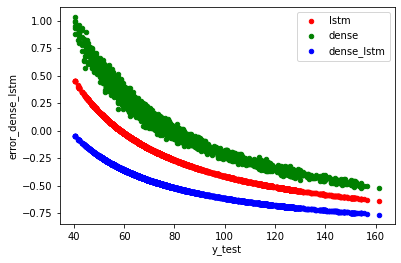

In [46]:
ax1 = all_results_df.plot(kind="scatter", x="y_test", color="r",
                    y="error_lstm", label="lstm")

ax2 = all_results_df.plot(kind="scatter", x="y_test", color="g",
                    y="error_dense", label="dense", ax=ax1)

ax3 = all_results_df.plot(kind="scatter", x="y_test", color="b",
                    y="error_dense_lstm", label="dense_lstm", ax=ax2)

<AxesSubplot:ylabel='Frequency'>

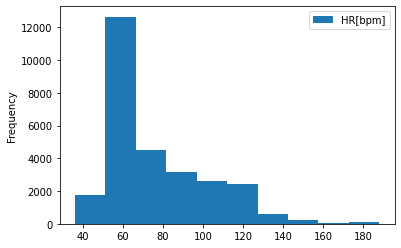

In [56]:
pat_data_df[["HR[bpm]"]].round().plot(kind="hist")

## Conclusions:

most of our data has labels around 60 bpm, and the error matches this trend:
- overestimating the 40 bpm
- and understimating the 60+ cases